### Импорты

In [1]:
import time

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from colorama import Fore
from typing import Final

from sklearn.preprocessing import OneHotEncoder

#### Загрузка данных

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

#### Смотрим, что всё загрузилось

In [3]:
def print_colored(text, color=Fore.GREEN):
    print(f"{color}{text}{Fore.RESET}")
    
print_colored(train_data.head())
print_colored(test_data.head(), color=Fore.BLUE)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

#### Находим пропажи

In [4]:
class MissingFeature:
    def __init__(self, name, miss_count, t):
        self.name: str = name
        self.miss_count: int = miss_count
        self.t: type = t

def missing_value_checker(data, need_print=True) -> list[MissingFeature]:
    missed: list[MissingFeature] = []
    for feature, content in data.items():
        if data[feature].isnull().values.any():
            s = data[feature].isna().sum()
            t = data[feature].dtype

            if need_print: print (f'{feature}: {s}, type: {t}')
            
            missed.append(MissingFeature(feature, s, t))
    if need_print:
        print(f'Data count: {len(data)}')
        print(f'Columns with missing values: {len(missed)}')
        print(list(map(lambda x: x.name, missed)))
    
    return missed

test_missed_list = missing_value_checker(test_data)

MSZoning: 4, type: object
LotFrontage: 227, type: float64
Alley: 1352, type: object
Utilities: 2, type: object
Exterior1st: 1, type: object
Exterior2nd: 1, type: object
MasVnrType: 894, type: object
MasVnrArea: 15, type: float64
BsmtQual: 44, type: object
BsmtCond: 45, type: object
BsmtExposure: 44, type: object
BsmtFinType1: 42, type: object
BsmtFinSF1: 1, type: float64
BsmtFinType2: 42, type: object
BsmtFinSF2: 1, type: float64
BsmtUnfSF: 1, type: float64
TotalBsmtSF: 1, type: float64
BsmtFullBath: 2, type: float64
BsmtHalfBath: 2, type: float64
KitchenQual: 1, type: object
Functional: 2, type: object
FireplaceQu: 730, type: object
GarageType: 76, type: object
GarageYrBlt: 78, type: float64
GarageFinish: 78, type: object
GarageCars: 1, type: float64
GarageArea: 1, type: float64
GarageQual: 78, type: object
GarageCond: 78, type: object
PoolQC: 1456, type: object
Fence: 1169, type: object
MiscFeature: 1408, type: object
SaleType: 1, type: object
Data count: 1459
Columns with missing va

#### Убираем невалидные данные и доставляем медиану, где пропусков мало

In [5]:
MAX_MISSING: Final[int] = 100

def clear_most_missed(test, train) -> tuple[DataFrame, DataFrame]:
    for feature in test_missed_list:
        if feature.miss_count < MAX_MISSING: continue
        test = test.drop(feature.name, axis=1)
        train = train.drop(feature.name, axis=1)
        
        print_colored(f'Removed column: {feature.name}, count: {feature.miss_count}', color=Fore.YELLOW)
    return test, train
        
def fill_none(data) -> None:
    for label, content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            data[label] = content.fillna(content.median())
        else:
            data[label] = content.astype("category").cat.as_ordered()
            data[label] = pd.Categorical(content).codes+1
        print_colored(f'Filled column {label}')
            
## Clear
test_data_edited, train_data_edited = clear_most_missed(test_data, train_data)

## Fill
fill_none(train_data_edited)
fill_none(test_data_edited)

Removed column: LotFrontage, count: 227
Removed column: Alley, count: 1352
Removed column: MasVnrType, count: 894
Removed column: FireplaceQu, count: 730
Removed column: PoolQC, count: 1456
Removed column: Fence, count: 1169
Removed column: MiscFeature, count: 1408
Filled column Id
Filled column MSSubClass
Filled column MSZoning
Filled column LotArea
Filled column Street
Filled column LotShape
Filled column LandContour
Filled column Utilities
Filled column LotConfig
Filled column LandSlope
Filled column Neighborhood
Filled column Condition1
Filled column Condition2
Filled column BldgType
Filled column HouseStyle
Filled column OverallQual
Filled column OverallCond
Filled column YearBuilt
Filled column YearRemodAdd
Filled column RoofStyle
Filled column RoofMatl
Filled column Exterior1st
Filled column Exterior2nd
Filled column MasVnrArea
Filled column ExterQual
Filled column ExterCond
Filled column Foundation
Filled column BsmtQual
Filled column BsmtCond
Filled column BsmtExposure
Filled 

#### Разделяем данные 80 на 20 для тренировки и теста результата

In [6]:
X = train_data_edited.drop('SalePrice', axis=1)
y = train_data_edited['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print_colored(X_train.shape, color=Fore.BLUE)
print_colored(test_data_edited.shape, color=Fore.GREEN)

(1168, 73)
(1459, 73)


In [7]:
import tensorflow as tf
from keras import Sequential
from keras import layers
print(tf.__version__)

2.18.0


#### Создаем класс для хранения различных комбинаций гиперпараметров моделей

In [8]:
class NamedModel:
    def __init__(self, 
        name: str, 
        epoches: int,
        batch_size: int,
        optimizer: str,
        loss: str,
        model: tf,
        color: str, 
        plot_color: str
    ) -> None:
        self.name = name
        self.epoches = epoches
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.loss = loss
        self.model = model
        self.color = color
        self.plot_color = plot_color
        
    def compile_model(self):
        self.model.compile(
            loss=self.loss, 
            optimizer=self.optimizer, 
            metrics=['mae']
        )
        
    def __str__(self):
        return f'{self.name}, {self.optimizer}\nb: {self.batch_size}, e: {self.epoches}\nloss: {self.loss}'
    
    def get_plot_title(self):
        return f'{self.name}\nopt:{self.optimizer},\nbs:{self.batch_size}\ne:{self.epoches}'
        
    def get_title_string(self) -> str:
        return f'{self.color}Next model - {self.name}{Fore.RESET}'
    
    def get_time_string(self, elapsed) -> str:
        return f'{self.color}Elapsed time: {round(elapsed, 3)}{Fore.RESET}'

#### Создаём список моделей с разными наборами гиперпараметров и параметров компиляции модели.

In [9]:
tf.random.set_seed(42)
input_layer = layers.InputLayer(X_train.shape[1:])

model_list: list[NamedModel] = [
    NamedModel(
        name='64r-32r',
        epoches=50,
        batch_size=32,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.CYAN,
        plot_color='c'
    ),
    NamedModel(
        name='64r-32r',
        epoches=100,
        batch_size=64,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.RED,
        plot_color='purple'
    ),
    NamedModel(
        name='128r-32r',
        epoches=100,
        batch_size=64,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.RED,
        plot_color='darkslateblue'
    ),
    NamedModel(
        name='128r-32r',
        epoches=100,
        batch_size=128,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.RED,
        plot_color='blueviolet'
    ),
    NamedModel(
        name='256r-128r-32r',
        epoches=200,
        batch_size=128,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.RED,
        plot_color='tomato'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=128,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='y'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=16,
        optimizer='adam',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='y'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=128,
        optimizer='Ftrl',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='teal'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=16,
        optimizer='Ftrl',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='teal'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=128,
        optimizer='AdaMax',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='peru'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=16,
        optimizer='AdaMax',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='peru'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=128,
        optimizer='Adadelta',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='c'
    ),
    NamedModel(
        name='512r-256l-128l-32r',
        epoches=200,
        batch_size=16,
        optimizer='Adadelta',
        loss='mse',
        model=Sequential([
            input_layer,
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(128, activation='linear'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        color=Fore.GREEN,
        plot_color='c'
    )
]

#### Компиляция моделей

In [10]:
for m in model_list:
    m.compile_model()

#### Тренировка и построение графиков результативности

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 35221843968.0000 - mae: 173374.7031 
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 28568430592.0000 - mae: 153990.6406
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 14878156800.0000 - mae: 102321.1406 
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 5480993280.0000 - mae: 49622.5703
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 4094196736.0000 - mae: 42742.9727
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 3731138048.0000 - mae: 41749.7383
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 3402851840.0000 - mae: 40909.3359
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 3223047424.0000 - mae: 40291.5195
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 3114090496.0000 - mae: 39889.9922
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 2973665536.0000 - mae: 39419.4766
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step 

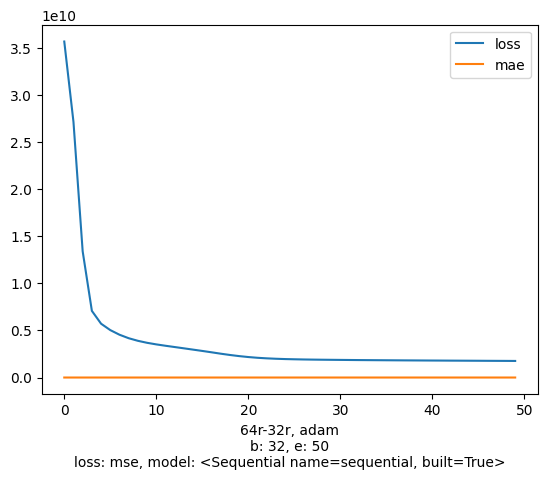

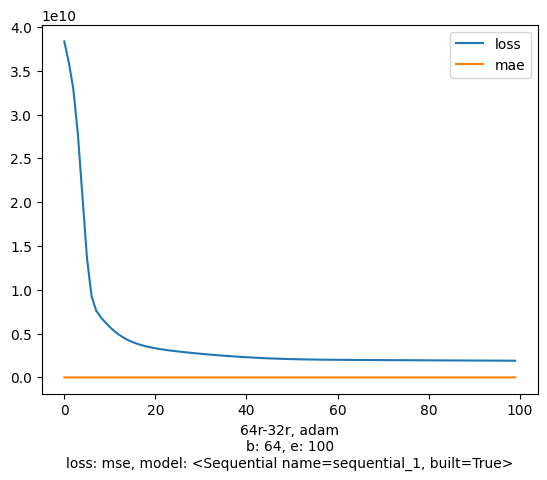

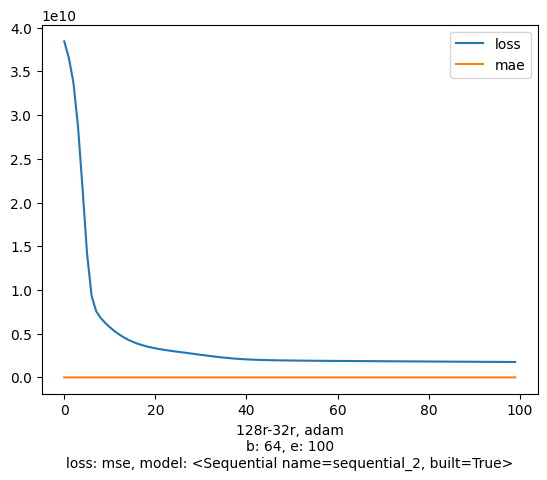

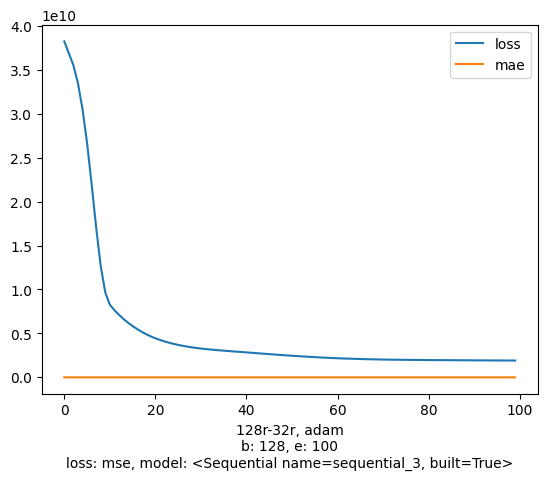

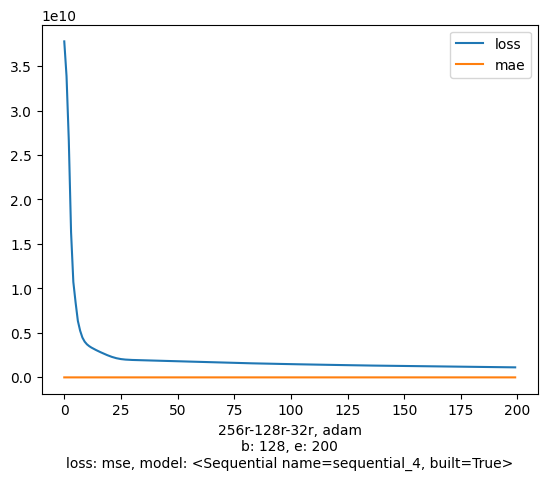

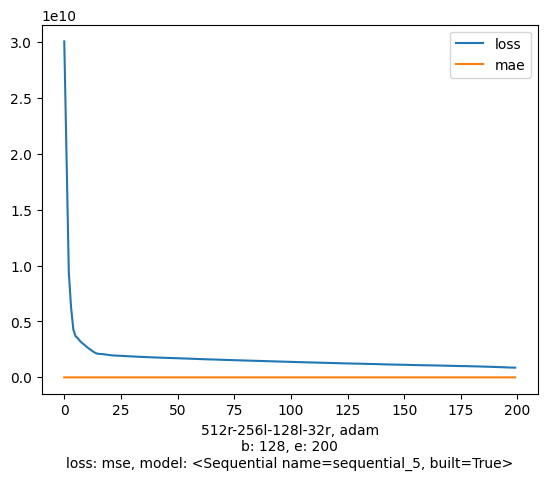

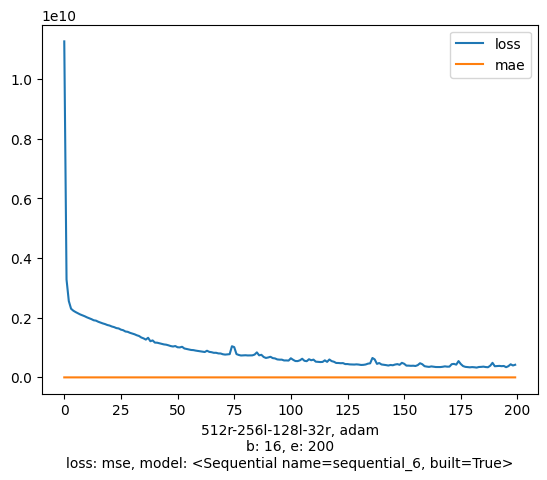

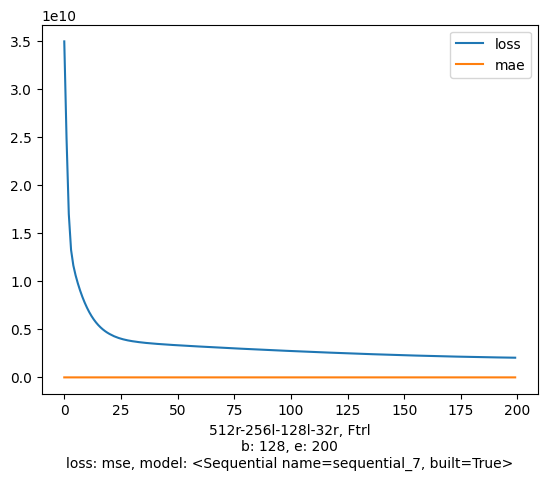

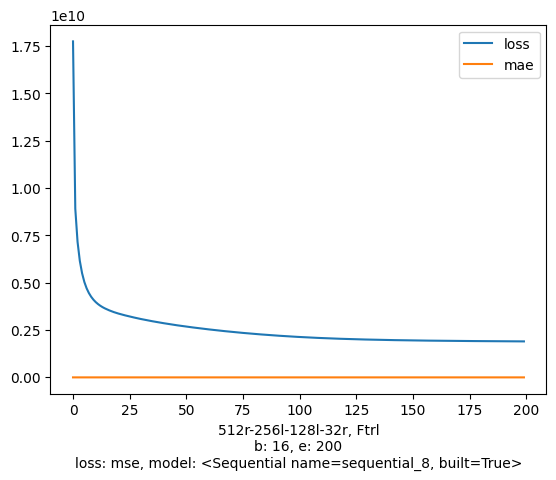

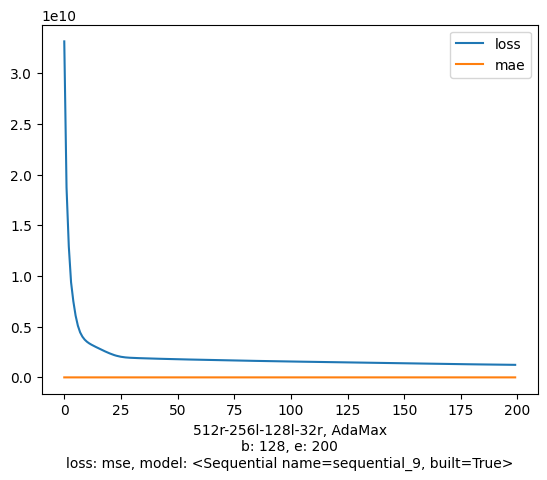

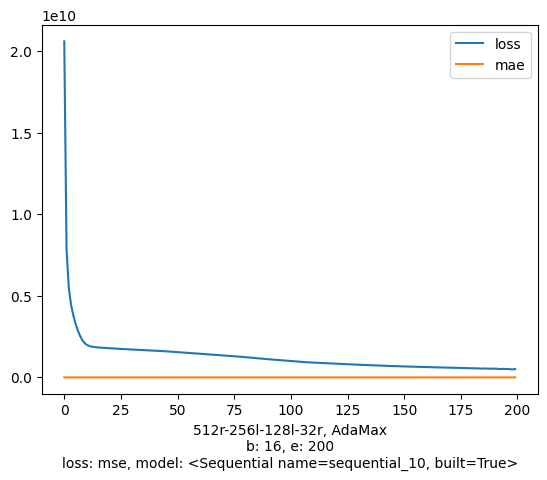

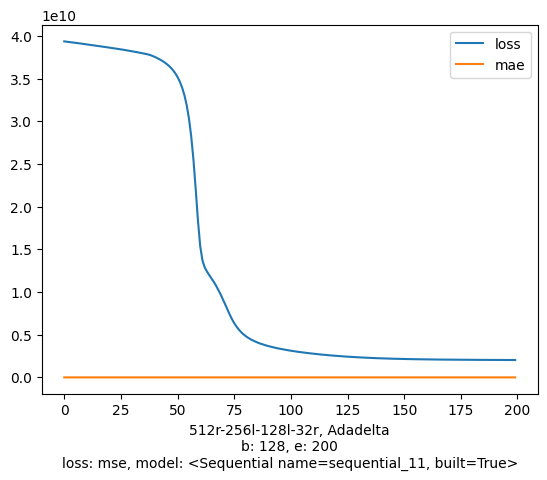

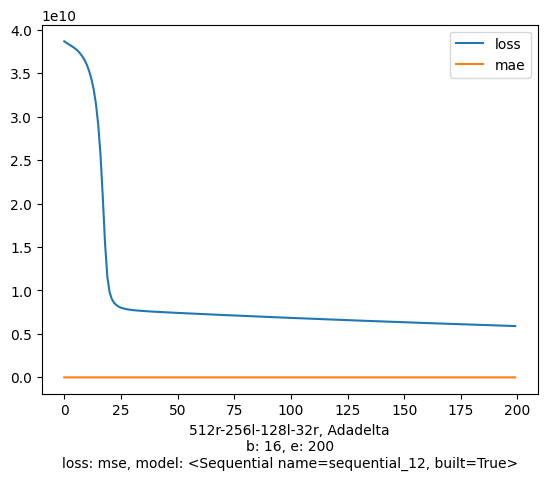

In [11]:
def process_model(nm: NamedModel):
    history = nm.model.fit(X_train, y_train, epochs=nm.epoches, batch_size=nm.batch_size)
    
    pd.DataFrame(history.history).plot()
    plt.xlabel(nm.get_plot_title())
    print(history.history)

start_time = time.time()
for nm in model_list:
    process_model(nm)
    
print(f"Learning time: {time.time() - start_time}")

#### Проверка общей эффективности на "отрезанных" 20% тренировочного набора

In [12]:
class Report:
    def __init__(self, mae, mae_percent):
        self.mae = mae
        self.mae_present = mae_percent

def evaluate_model(nm: NamedModel) -> Report:
    elapsed_time = time.time()
    test_loss, test_mae = nm.model.evaluate(X_val, y_val, verbose=0)
    elapsed_time = time.time() - elapsed_time
    mae_percent = round(100*test_mae/mean_sale_price, 2)
    
    print_colored(f'{str(nm)}: present error = {mae_percent}, elapsed = {round(elapsed_time, 5)}, loss = {test_loss}, mae = {test_mae}')
    
    return Report(test_mae, mae_percent)
    
mean_sale_price = round(y_val.mean())
print_colored(f"Mean value = {mean_sale_price}", color=Fore.CYAN)

reports: list[Report] = []
    
for nm in model_list:
    reports.append(evaluate_model(nm))
    

Mean value = 178840
64r-32r, adam
b: 32, e: 50
loss: mse, model: <Sequential name=sequential, built=True>: present error = 14.57, elapsed = 0.11273, loss = 1685957632.0, mae = 26050.16796875
64r-32r, adam
b: 64, e: 100
loss: mse, model: <Sequential name=sequential_1, built=True>: present error = 15.07, elapsed = 0.11722, loss = 1767281664.0, mae = 26953.078125
128r-32r, adam
b: 64, e: 100
loss: mse, model: <Sequential name=sequential_2, built=True>: present error = 14.69, elapsed = 0.09915, loss = 1707022592.0, mae = 26276.568359375
128r-32r, adam
b: 128, e: 100
loss: mse, model: <Sequential name=sequential_3, built=True>: present error = 15.18, elapsed = 0.09468, loss = 1793188480.0, mae = 27151.07421875
256r-128r-32r, adam
b: 128, e: 200
loss: mse, model: <Sequential name=sequential_4, built=True>: present error = 12.77, elapsed = 0.10007, loss = 1237397760.0, mae = 22838.3671875
512r-256l-128l-32r, adam
b: 128, e: 200
loss: mse, model: <Sequential name=sequential_5, built=True>: pre

#### Построение разных графиков

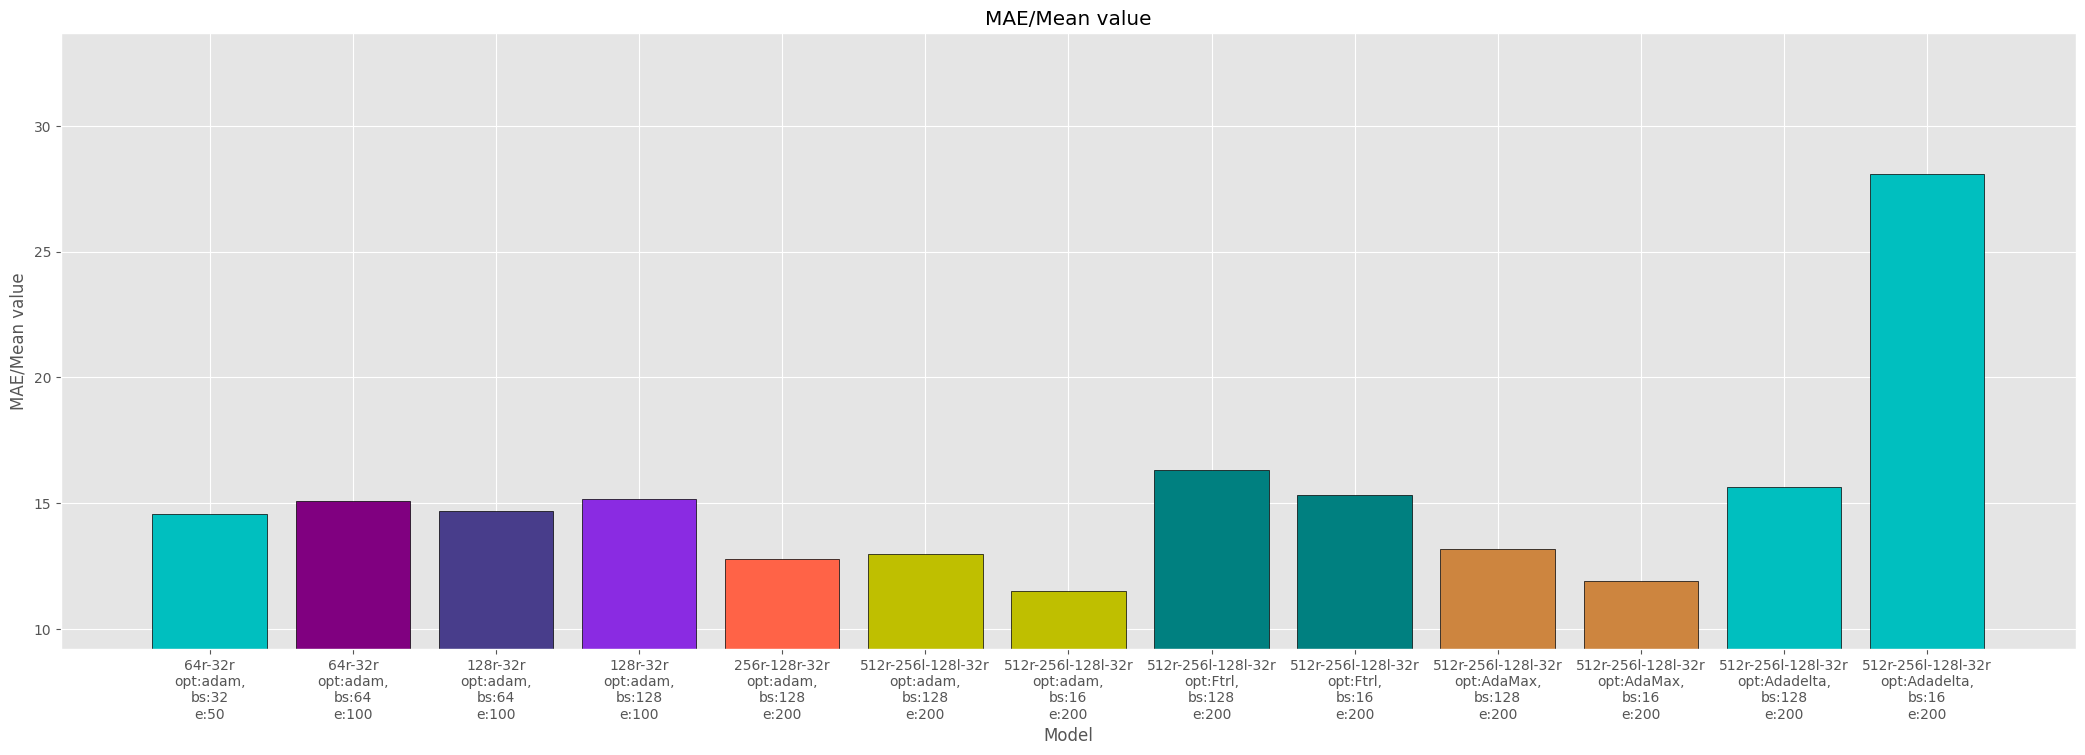

In [14]:
def build_report_plot(nms: list[NamedModel], vals: list[int], title: str) -> None:
    plt.style.use('ggplot')
    plt.figure(figsize=(26, 8))
    names = list(map(lambda x: x.get_plot_title(), nms))
    
    plt.bar(
        names, 
        vals,
        color=list(map(lambda x: x.plot_color, nms)), 
        edgecolor='black'
    )

    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(title)
    
    min_value = min(vals)
    max_value = max(vals)
    plt.ylim(min_value * 0.8, max_value * 1.2)
    
    plt.show()
    
    
percents = list(map(lambda x: x.mae_present, reports))
maes = list(map(lambda x: x.mae, reports))
build_report_plot(model_list, percents, title='MAE/Mean value')
# build_report_plot(model_list, maes, title='MAE')

### Прогнозирование
Проводим прогнозирование на самой эффективной модели, в данном случае 7-ая модель со слоями 512relu-256linear-128linear-32relu, оптимизатором adam, batch_size = 16, epoches = 200.

In [16]:
bestNamedModel = model_list[6]
print_colored(bestNamedModel.get_plot_title(), color=Fore.YELLOW)

512r-256l-128l-32r
opt:adam,
bs:16
e:200


In [17]:
import numpy as np

predicts = bestNamedModel.model.predict(test_data_edited)

output = pd.DataFrame(
{
    'Id':test_data['Id'],
    'SalePrice': np.squeeze(predicts)
})
print(output)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
        Id      SalePrice
0     1461  134952.218750
1     1462  126525.179688
2     1463  187983.093750
3     1464  193610.953125
4     1465  189346.062500
...    ...            ...
1454  2915   70209.468750
1455  2916   68449.859375
1456  2917  172204.390625
1457  2918  116310.125000
1458  2919  225240.921875

[1459 rows x 2 columns]


### Вопросы по работе.
---
#### Как выше перечисленные параметры влияют на полученный вами результат?
---
#### Что такое эпоха (Epoch)? В чем отличие от итерации (Iteration)?
---
#### Что такое функция активации? Какие вам известны? Как и зачем используются в нейронной сети?
---
#### Что такое MSE(Mean Squared Error) - Средняя квадратичная ошибка? Что такое MAE(Mean Absolute Error)? Для чего используются.